In [1]:
# import libraries
import pandas as pd 
import numpy as np
from scipy import sparse 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading in dataframes
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')

#### ratings df

In [3]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [4]:
ratings.shape

(100836, 4)

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
# tally number of users
# 610 users
viewers = ratings['userId'].unique()
len(viewers)

610

In [7]:
# adverage rating 3.5 with a maximum movie rating of 5.0
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

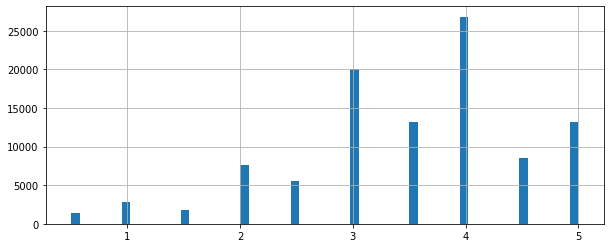

In [8]:
# majority of the ratings lay between 3 and 4
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=60)

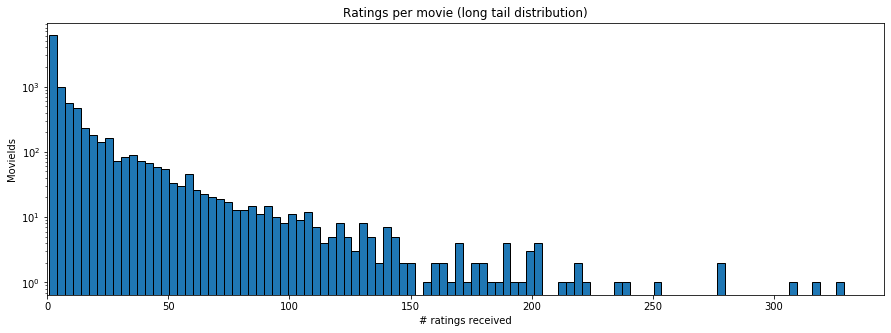

In [9]:
# Histogram of ratings counts.
rate_dist = ratings[['userId', 'movieId']].groupby('movieId').count()
rate_dist.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.hist(rate_dist.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per movie (long tail distribution)')
plt.xlabel('# ratings received')
plt.ylabel('MovieIds')
plt.xlim(0,)
plt.show()

#### movies df

In [10]:
# no meta data! 
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
movies.shape

(9742, 3)

In [12]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [13]:
# tally number of movies 9737
# number of movies out number the users may lead to noise in the data set 
# since there are many possible non rated movies
films = movies['title'].unique()
len(films)

9737

#### merge

In [14]:
# dropping timestamp
ratings = pd.merge(movies, ratings).drop(['timestamp'], axis= 1)
ratings.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


#### pivot_table

In [15]:
# numerous NaN's many unrated or low-level rated films as expected
user_ratings = ratings.pivot_table(index=['userId'], columns=['title'], values='rating')
user_ratings.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### dropna() with  threshold

In [16]:
# remove any films with < 10 users rating, and remaing NaN changed to 0 values
# threshold can be easily adjusted to allow for more films, this is occuring on column data axis 1
user_ratings = user_ratings.dropna(thresh= 10, axis=1).fillna(0,axis=1)
user_ratings.head(5)

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### similarity matrix

Cosine similarity

In [17]:
# to compute a similarity score three options are available: euclidean, correlation (pearson), and cosine
tfV = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfV_matrix = tfV.fit_transform(movies['genres'])

cosine_similarity = linear_kernel(tfV_matrix, tfV_matrix)

Pearson similarity

In [39]:
# corr(pearson) method adjusts for the mean by default so no further need to standardize. 
pearson_similarity = user_ratings.corr(method='pearson')
pearson_similarity.tail()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
title,,,,,,,,,,,,,,,,,,,,,
Welcome to the Dollhouse (1995),0.083112,0.054483,-0.028815,0.212621,0.059257,0.110430,0.143640,-0.006319,0.026965,-0.004311,...,0.109712,0.031396,0.184711,0.127851,0.099687,0.103865,0.018217,0.145918,0.079842,0.160409
"Wes Craven's New Nightmare (Nightmare on Elm Street Part 7: Freddy's Finale, A) (1994)",0.026030,-0.019626,-0.019653,-0.001533,-0.020954,0.077273,0.026009,-0.040680,0.012194,0.011466,...,-0.023971,0.052160,0.058827,-0.014533,0.005691,-0.012114,0.033106,0.051398,0.091244,0.017359
West Side Story (1961),0.123680,0.097541,-0.034552,0.135083,0.015004,0.180786,0.299342,0.143818,0.050516,0.068129,...,0.027337,0.066106,0.193926,0.122377,0.028824,0.139260,0.012696,0.191741,0.038304,0.176259
Westworld (1973),0.177836,-0.027558,-0.025889,0.004790,-0.027603,0.122447,0.159334,0.039119,-0.027810,-0.029298,...,-0.031578,0.045854,-0.026897,-0.043141,-0.021766,0.041449,0.023528,0.066347,0.025996,0.054122
Whale Rider (2002),0.061608,0.087250,-0.022039,0.182027,0.023984,0.016517,0.285401,0.085488,0.039165,-0.024940,...,0.094462,0.159326,0.111236,0.070706,0.077954,0.138781,0.054450,0.160119,0.202057,0.084378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zoolander (2001),0.049897,0.252226,0.195054,0.281934,0.240231,0.184324,0.274260,0.122107,0.017351,0.091416,...,0.304364,0.243820,-0.006269,0.242033,0.299522,1.000000,0.108147,0.097147,0.338034,0.109455
Zootopia (2016),0.003233,0.216007,0.319371,0.050031,0.094773,0.054024,0.077594,0.056742,0.063325,0.225747,...,0.286213,0.156603,0.011418,0.214385,0.298504,0.108147,1.000000,0.046885,0.200762,0.020595
eXistenZ (1999),0.187953,0.053614,0.177846,0.121029,0.088045,0.047804,0.085606,-0.001708,0.002528,0.128638,...,0.088202,0.028566,0.167541,0.145741,0.068763,0.097147,0.046885,1.000000,0.163022,0.138611


#### making predictions

Cold start genre-based recommendations

In [19]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# only title parameter
def genre_based_recommendations(title):
    idx = indices[title]
    similarity_scores = list(enumerate(cosine_similarity[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:11]
    movie_indices = [i[0] for i in similarity_scores]

    return titles.iloc[movie_indices]

User ratings-based recommendations 

In [20]:
def get_similar_movies(movie_name, user_rating):
    # weighted user ratings 
    similar_score = pearson_similarity[movie_name] * (user_rating-2.5)
    # valid values at top of the returned values
    similar_score = similar_score.sort_values(ascending= False)
    
    return similar_score

In [45]:
# rating_based recommendations
user = [('Scott Pilgrim vs. the World (2010)', 1), ('2001: A Space Odyssey (1968)', 4), ('Zoolander (2001)', 3)]

# empty dataframe to hold values
similar_movies = pd.DataFrame()
    
for movie, rating in user:
    similar_movies = similar_movies.append(get_similar_movies(movie, rating), ignore_index = True)

2001: A Space Odyssey (1968)             1.280072
Blade Runner (1982)                      0.671624
African Queen, The (1951)                0.627018
Lawrence of Arabia (1962)                0.622976
2010: The Year We Make Contact (1984)    0.616504
North by Northwest (1959)                0.596037
Abyss, The (1989)                        0.587159
Untouchables, The (1987)                 0.586499
Clockwork Orange, A (1971)               0.570817
Chinatown (1974)                         0.568316
dtype: float64

In [46]:
similar_movies.sum().sort_values(ascending=False).head(10)

2001: A Space Odyssey (1968)             1.280072
Blade Runner (1982)                      0.671624
African Queen, The (1951)                0.627018
Lawrence of Arabia (1962)                0.622976
2010: The Year We Make Contact (1984)    0.616504
North by Northwest (1959)                0.596037
Abyss, The (1989)                        0.587159
Untouchables, The (1987)                 0.586499
Clockwork Orange, A (1971)               0.570817
Chinatown (1974)                         0.568316
dtype: float64

In [22]:
# genre based recommendations
genre_based_recommendations('Zombieland (2009)')

7154                                    Zombieland (2009)
8434                                    Zombeavers (2014)
8565                    Dead Snow 2: Red vs. Dead (2014) 
9035         Scouts Guide to the Zombie Apocalypse (2015)
62                             From Dusk Till Dawn (1996)
6251                             Snakes on a Plane (2006)
6324                                         Feast (2005)
11                     Dracula: Dead and Loving It (1995)
654     Tales from the Crypt Presents: Bordello of Blo...
1478                                      Gremlins (1984)
Name: title, dtype: object

#### PySpark |  ALS

In [23]:
# import necessary libraries
from pyspark.sql import SparkSession
# instantiate SparkSession object
# spark = SparkSession.builder.master('local').getOrCreate()
spark = SparkSession\
        .builder\
        .appName('ALSExample').config('spark.driver.host', 'localhost')\
        .getOrCreate()

# read in the dataset into pyspark DataFrame
movie_ratings = spark.read.csv('./data/ratings.csv', header='true', inferSchema='true')

In [24]:
movie_ratings.dtypes

[('userId', 'int'),
 ('movieId', 'int'),
 ('rating', 'double'),
 ('timestamp', 'int')]

In [25]:
movie_ratings = movie_ratings.drop('timestamp')

In [26]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS 

In [27]:
# split into training and testing sets
(training, test) = movie_ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop')

# fit the ALS model to the training set
model = als.fit(training)

In [28]:
from pyspark.ml.evaluation import RegressionEvaluator

In [29]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))
# Root-mean-square error = 1.003387841231623 Ouch that's awful > 0.5

Root-mean-square error = 1.0036436073228883


Cross-validation to find optimal model

In [30]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [31]:
# initialize the ALS model
als_model = ALS(userCol='userId', itemCol='movieId', 
                ratingCol='rating', coldStartStrategy='drop')

# create the parameter grid                 
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.01, 0.001, 0.1])\
          .addGrid(als_model.rank, [4, 10, 50]).build()

# instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)

best_model = cv.fit(movie_ratings)   

Incorporating the names of the movies

In [32]:
movie_titles = spark.read.csv('./data/movies.csv', header='true', inferSchema='true')
movie_titles.head(5)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy'),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance'),
 Row(movieId=4, title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance'),
 Row(movieId=5, title='Father of the Bride Part II (1995)', genres='Comedy')]

In [33]:
def name_retriever(movie_id, movie_title_df):
    return movie_title_df.where(movie_title_df.movieId == movie_id).take(1)[0]['title']
print(name_retriever(1023, movie_titles))

Winnie the Pooh and the Blustery Day (1968)


Getting recommendations

In [34]:
users = movie_ratings.select(als.getUserCol()).distinct().limit(1)
userSubsetRecs = model.recommendForUserSubset(users, 10)
recs = userSubsetRecs.take(1)

In [35]:
# use indexing to obtain the movie id of top predicted rated item
first_recommendation = recs[0]['recommendations'][0][0]
# use the name retriever function to get the values
name_retriever(first_recommendation,movie_titles)

'Titanic (1953)'

In [36]:
recommendations = model.recommendForAllUsers(5)
recommendations.where(recommendations.userId == 3).collect()

[Row(userId=3, recommendations=[Row(movieId=5034, rating=9.377350807189941), Row(movieId=7883, rating=8.714156150817871), Row(movieId=2488, rating=8.658651351928711), Row(movieId=4476, rating=8.498205184936523), Row(movieId=6380, rating=8.338815689086914)])]

Rate new movies

In [37]:
def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # split the dataframe into a train and test set
    (training, test) = movie_ratings_combined.randomSplit([0.8, 0.2],seed=0)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5,rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id,movie_title_df)
        print('Recommendation {}: {}  | predicted score :{}'.format(ranking+1,movie_string,rating))

In [38]:
user_id = 100000
user_ratings_1 = [(user_id,3253,5),
                  (user_id,2459,5),
                  (user_id,2513,4),
                  (user_id,6502,5),
                  (user_id,1091,5),
                  (user_id,441,4)]
new_user_recs(user_id,
             new_ratings=user_ratings_1,
             rating_df=movie_ratings,
             movie_title_df=movie_titles,
             num_recs = 10)

Recommendation 1: Casablanca (1942)  | predicted score :5.627026081085205
Recommendation 2: Star Wars: Episode IV - A New Hope (1977)  | predicted score :5.600255966186523
Recommendation 3: Godfather, The (1972)  | predicted score :5.561194896697998
Recommendation 4: Back to the Future (1985)  | predicted score :5.526130199432373
Recommendation 5: Princess Bride, The (1987)  | predicted score :5.51720666885376
Recommendation 6: Shawshank Redemption, The (1994)  | predicted score :5.471886157989502
Recommendation 7: Silence of the Lambs, The (1991)  | predicted score :5.462902545928955
Recommendation 8: Star Wars: Episode V - The Empire Strikes Back (1980)  | predicted score :5.422360420227051
Recommendation 9: American Beauty (1999)  | predicted score :5.415508270263672
Recommendation 10: Indiana Jones and the Last Crusade (1989)  | predicted score :5.397063255310059
